Import the libraries necessary to analize data

In [924]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

In [925]:
df = pd.read_csv('incidents_df_joined.csv', low_memory=False, sep=',', parse_dates=['date'])

Casting data types to match the content of each attribute (these instructions also set to NaN non-numerical values in numerical attributes)

In [926]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("Float64")
df["participant_gender1"] = df["participant_gender1"].astype("string")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Float64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Float64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Float64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Float64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Float64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Float64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Float64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df["party"] = df["party"].astype("string")
df["candidatevotes"] = df["candidatevotes"].astype("Int64")
df["totalvotes"] = df["totalvotes"].astype("Int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188721 entries, 0 to 188720
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       188720 non-null  datetime64[ns]
 1   state                      188720 non-null  string        
 2   city_or_county             188720 non-null  string        
 3   address                    175594 non-null  string        
 4   latitude                   188667 non-null  float64       
 5   longitude                  188667 non-null  float64       
 6   congressional_district     188720 non-null  Int64         
 7   state_house_district       167628 non-null  Int64         
 8   state_senate_district      173655 non-null  Int64         
 9   participant_age1           129384 non-null  Int64         
 10  participant_age_group1     152582 non-null  string        
 11  participant_gender1        157675 non-null  string  

Deleting the rows with all NaN values

In [927]:
print(f"df len before: {len(df)}")
df.dropna(how='all', inplace=True)
print(f"df len after: {len(df)}")

df len before: 188721
df len after: 188720


Removing duplicates

In [928]:
print("Before duplicate removal")
print(df.duplicated().value_counts())
df = df.drop_duplicates(keep='first')
print("\nAfter duplicate removal")
print(df.duplicated().value_counts())

Before duplicate removal
False    188468
True        252
Name: count, dtype: int64

After duplicate removal
False    188468
Name: count, dtype: int64


Setting negative values (less than 0) to NaN, for all numerical attributes related to the incident participants

In [929]:
columns_to_check = ['participant_age1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants']
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df.loc[df[i] < 0, i] = np.nan


## Age
('participant_age1', 'min_age_participants', 'avg_age_participants', 'max_age_participants')


As seen in D.U., given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN, considering that a person with more than 120 years has not ever lived, here the [source](https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people).

In [930]:
df.loc[(df["avg_age_participants"] > 120), "avg_age_participants"] = np.nan
df.loc[(df['min_age_participants'] > 120), "min_age_participants"] = np.nan
df.loc[(df['max_age_participants'] > 120), "max_age_participants"] = np.nan
df.loc[(df["participant_age1"] > 120), "participant_age1"] = np.nan

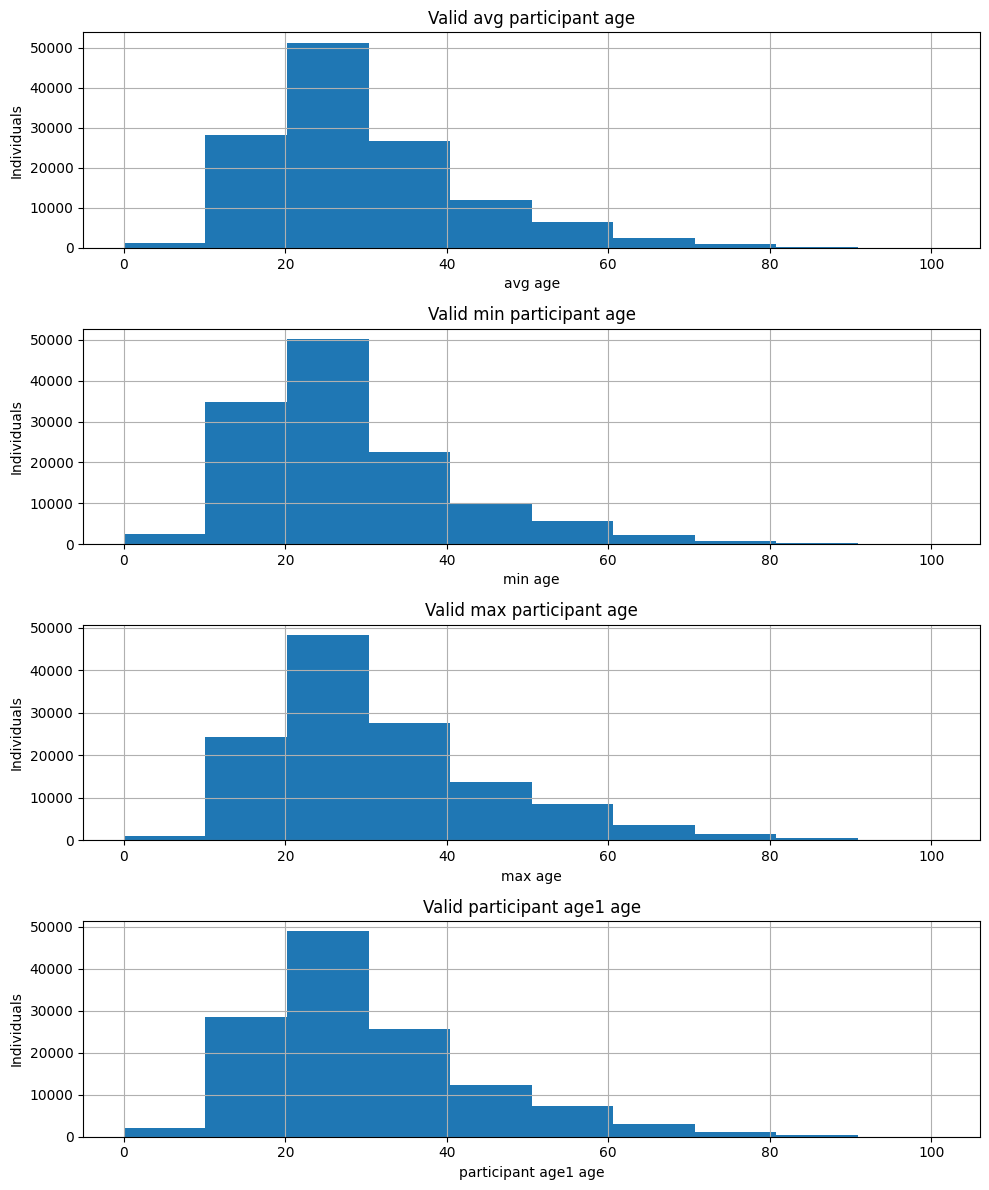

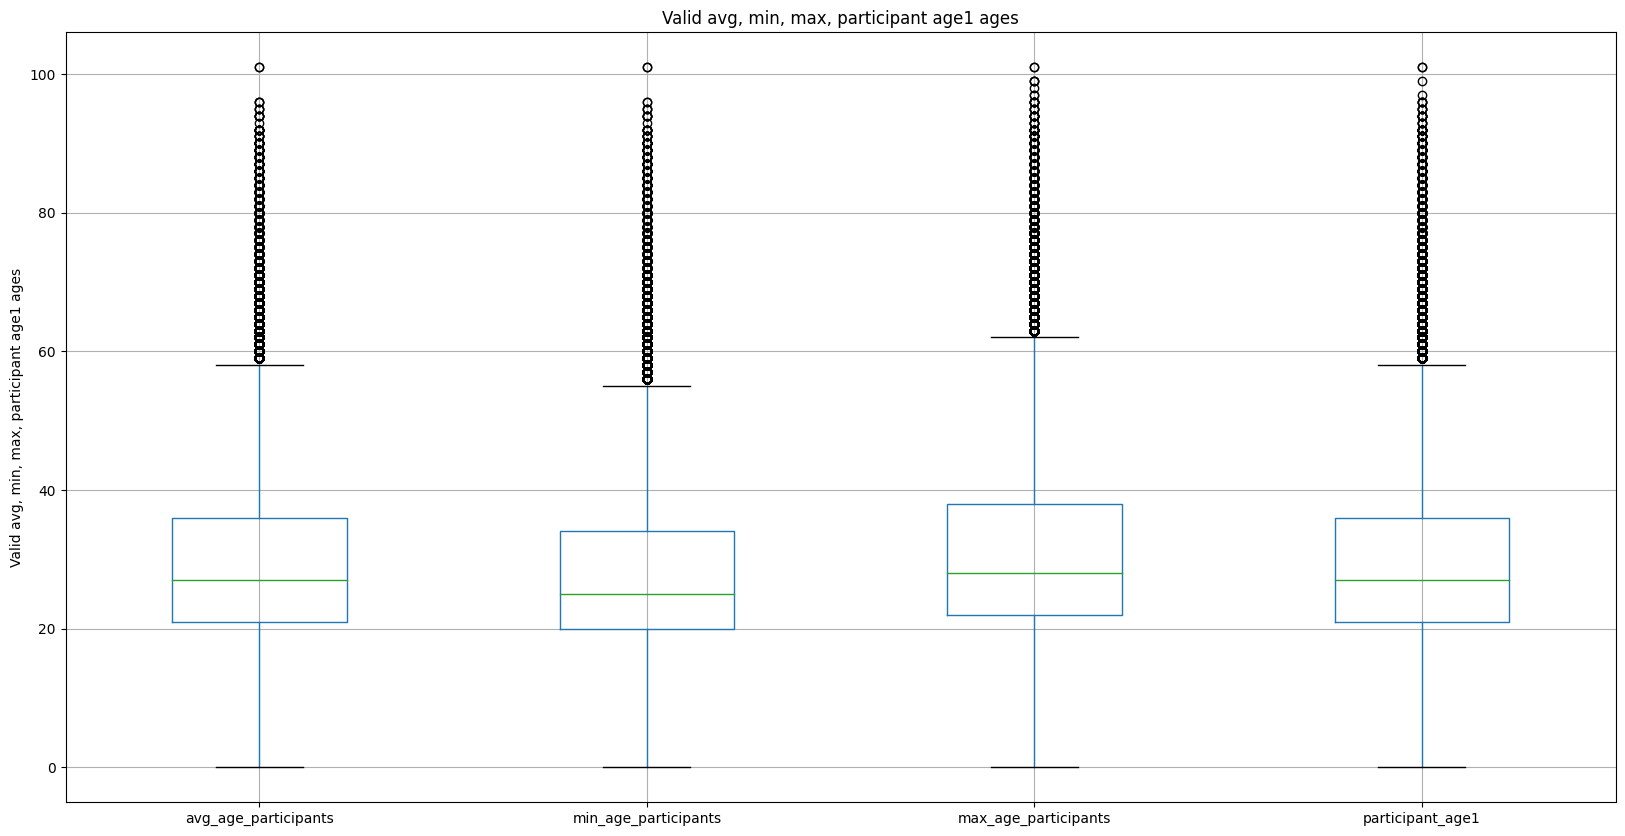

In [931]:
columns = ['avg_age_participants','min_age_participants','max_age_participants', 'participant_age1']
fig, axs = plt.subplots(4, figsize=(10, 12))  # Create 5 subplots

titles = ["Valid avg participant age", "Valid min participant age", "Valid max participant age", "Valid participant age1 age"]
xlabels = ["avg age", "min age", "max age", "participant age1 age"]
ylabels = ["Individuals"] * 4  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()

df.boxplot(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'], figsize=(20,10))
plt.title("Valid avg, min, max, participant age1 ages")
plt.ylabel("Valid avg, min, max, participant age1 ages")
plt.show()

In [932]:
df[['avg_age_participants', 'participant_age1', 'min_age_participants', 'max_age_participants']].describe()

,avg_age_participants,participant_age1,min_age_participants,max_age_participants
count,129364.0,129364.0,129368.0,129365.0
mean,29.956526,30.248323,28.312079,31.741754
std,12.461089,13.344242,12.498503,13.704309
min,0.0,0.0,0.0,0.0
25%,21.0,21.0,20.0,22.0
50%,27.0,27.0,25.0,28.0
75%,36.0,36.0,34.0,38.0
max,101.0,101.0,101.0,101.0


We notice from eliminated obvious outliers (>120 and <0 years of age) and plotting the results that [avg_age,min_age,max_age]_participants are very similar (same min and max age, similar mean and median), so we decide that we will further explore their correlation. 

We check if when avg_age_participants is 0 or null, we can infer it by calcultating the avg based on min_age_participants and max_age_participants, and we found 0 rows available.
This is a further motivation to delete min and max age participants

In [933]:
df[((df['avg_age_participants'] == 0) | (df['avg_age_participants'].isna())) & (((df['min_age_participants'] > 0) & (df['min_age_participants'].notna())) & ((df['max_age_participants'] > 0) & df['min_age_participants'].notna() ))] [['avg_age_participants', 'min_age_participants', 'max_age_participants']]

,avg_age_participants,min_age_participants,max_age_participants


## Date

Analysis and cleaning of the date attribute

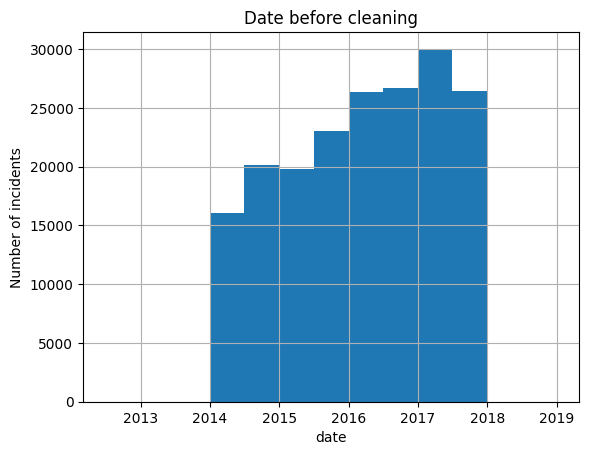

In [934]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date before cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

We considered all dates after 2023-10-01 (the date we received the dataset) to be ouliers, in particular error in the data

As seen in D.U., the year 2013 is under represented with only 242 records, so we decide to drop them. 

We decided also to drop temporarily records with year 2018 in the dataset (and probably analyze them separately after.) 

In [935]:
df['date'].dt.year.value_counts().sort_index()

date
2014    36248
2015    42804
2016    53051
2017    56365
Name: count, dtype: int64

14.091  

In [936]:
df_with_2013_2018 = len(df)
df = df[(df['date'].dt.year > 2013) & (df['date'].dt.year < 2018)]
print(df_with_2013_2018 - len(df))

0


In [937]:
df['date'].dt.year.value_counts().sort_index()

date
2014    36248
2015    42804
2016    53051
2017    56365
Name: count, dtype: int64

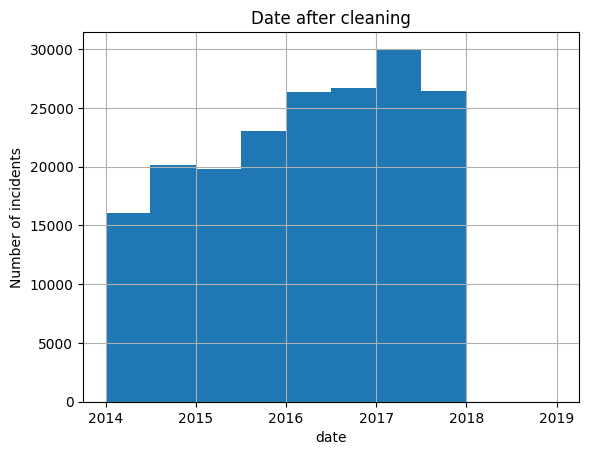

In [938]:
df.hist(column=["date"],   bins=[ datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date after cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

# Geographical info
('latitude', 'longitude', 'congressional_district', 'state_house_district', 'state_senate_district')

## Latitude and longitude

We consider the triple <date,latitude,longitude> to be a key identifying an incident. We decided to eliminate the records with these 3 values duplicates, because seeing also the notes and the incidents characteristics, the records with the same key represent the same incident  

In [939]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date', 'incident_characteristics1', 'notes']].value_counts()

latitude  longitude  date        incident_characteristics1                          notes                                            
29.7849   -95.3335   2016-05-16  Shot - Wounded/Injured                             1 inj.                                               2
38.5844   -121.4940  2014-03-20  ATF/LE Confiscation/Raid/Arrest                    ATF/LE                                               2
29.3663   -98.4417   2015-12-25  Shot - Dead (murder, accidental, suicide)          1 killed following argument                          2
43.2340   -86.2514   2017-02-28  Non-Shooting Incident                              Approximate date of sentencing.                      2
32.4125   -93.7938   2014-05-04  Possession (gun(s) found during commission of ...  armed robbery at McDonalds                           2
                                                                                                                                        ..
33.5667   -101.9170  2015-09-13 

In [940]:
print(f"records before cleaning: {len(df)}")
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(f"records after cleaning: {len(df)}")

records before cleaning: 188468


records after cleaning: 187543


In [941]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date']].value_counts()

Series([], Name: count, dtype: int64)

## Filling of missing values and outliers

We decide to repalce NaN value for latitude and longitude with the mean values for latitude and longitude in the same state and in the same city_or_county.

In [942]:

df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"],group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state",group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']].isna().any()

latitude     False
longitude    False
dtype: bool

## Congressional District, State House District, State Senate District

By examining the columns ‘congressional_district’, ‘state_house_district’, and ‘state_senate_district’, we observe that the columns ‘state_house_district’ and ‘state_senate_district’ represent further subdivisions of the US territory, which are not pertinent to our analysis. We will utilize the ‘congressional_district’ column to study the territorial divisions.

In [943]:
df.drop(columns=['state_house_district', 'state_senate_district'], inplace=True)

# Participant quantity information 
('n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants')

## N participants [child, teen, adult] and n males and n females

As we observed in D.U., for n_participants[_child,_teen,_adult] there are outliers represented by enormous values. In data preparation, we decided to clean these data putting them to nan, using the max of the n_participants column (which has no significantly big values).

In [944]:
# n_participants has no evident outliers as seen in D.U., we use max participants as threshold value to filter out the outliers
max_participants = df['n_participants'].max()

df.loc[(df["n_participants_child"] > max_participants), "n_participants_child"] = np.nan
df.loc[(df["n_participants_teen"] > max_participants), "n_participants_teen"] = np.nan
df.loc[(df["n_participants_adult"] > max_participants), "n_participants_adult"] = np.nan

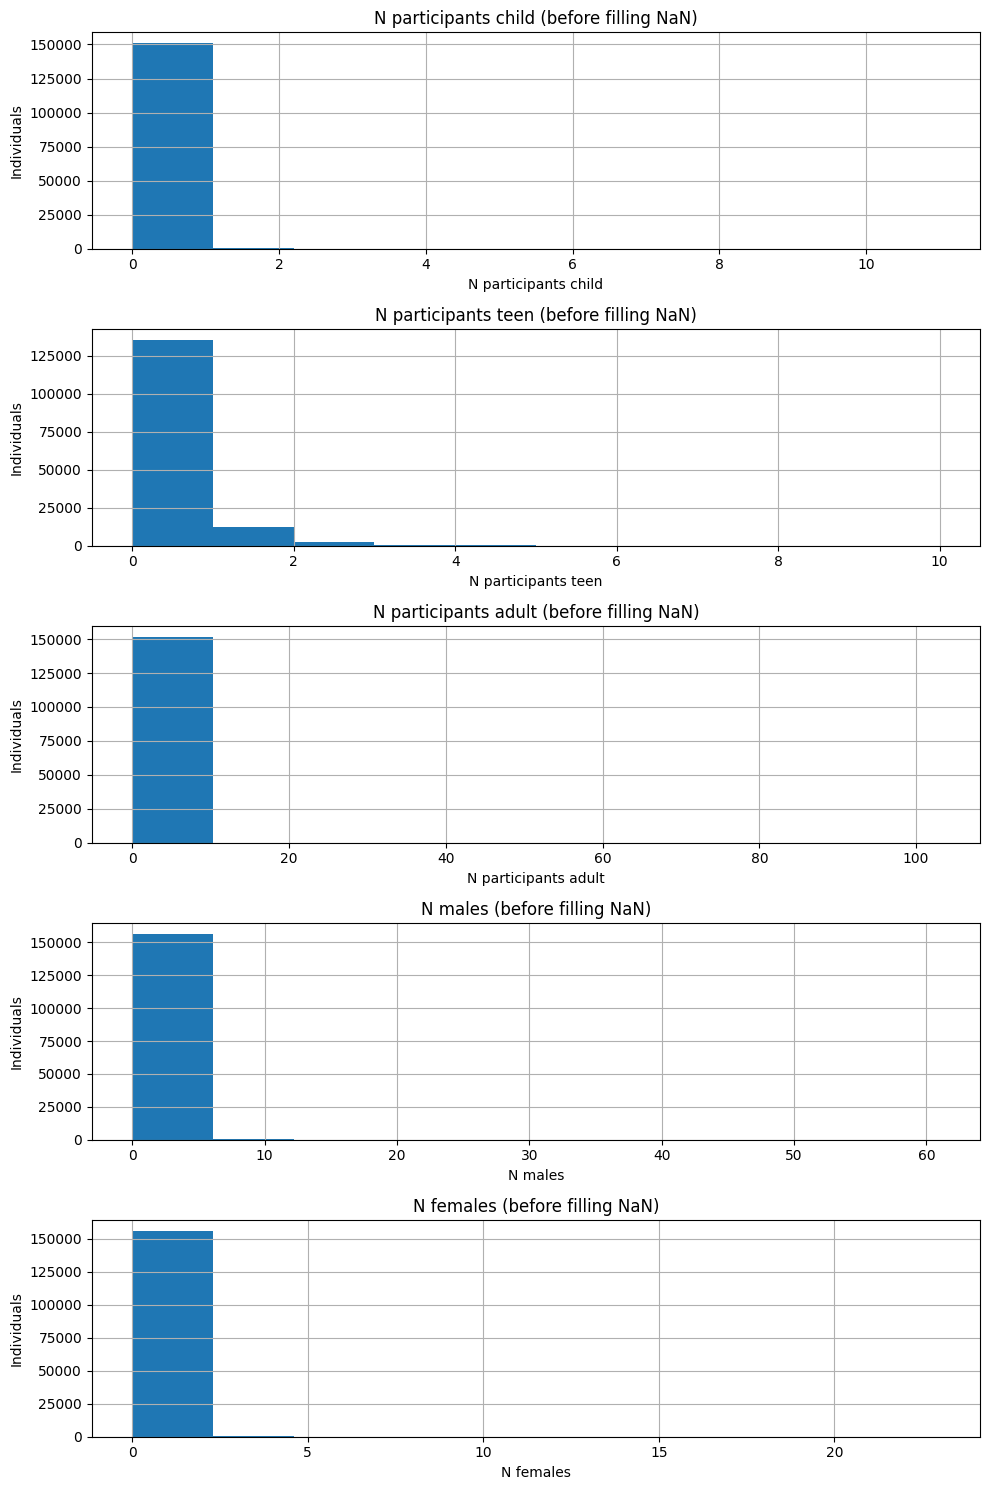

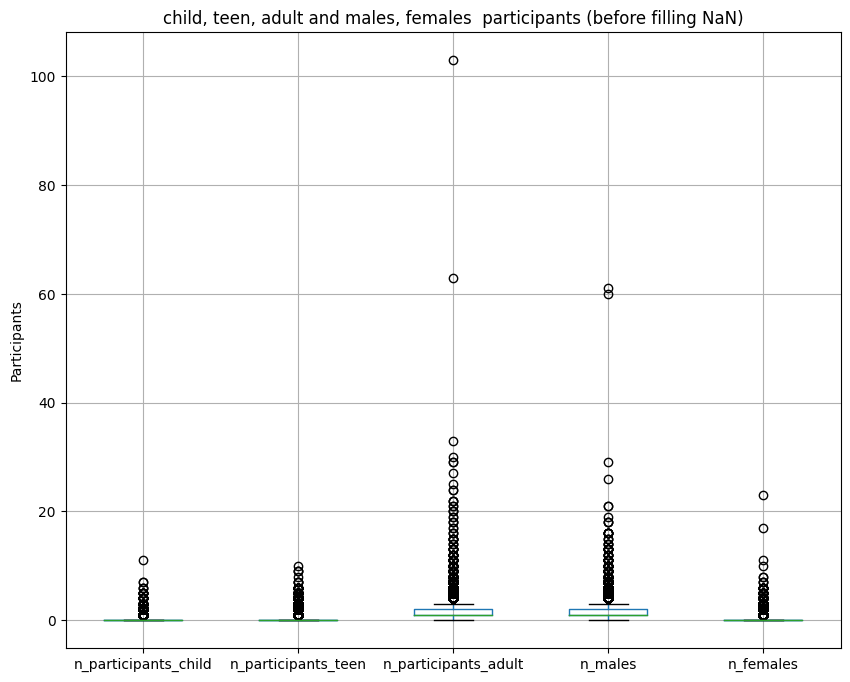

In [945]:
fig, axs = plt.subplots(5, figsize=(10, 15))  # Create 5 subplots

columns = ["n_participants_child", "n_participants_teen", "n_participants_adult", "n_males", "n_females"]
titles = ["N participants child (before filling NaN)", "N participants teen (before filling NaN)", "N participants adult (before filling NaN)", "N males (before filling NaN)", "N females (before filling NaN)"]
xlabels = ["N participants child", "N participants teen", "N participants adult", "N males", "N females"]
ylabels = ["Individuals"] * 5  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()


df.boxplot(column=["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"],  figsize=(10,8))
plt.title("child, teen, adult and males, females  participants (before filling NaN)")
plt.ylabel("Participants")
plt.show()

In [946]:
df[columns].describe()

,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
count,151878.0,151878.0,151878.0,156943.0,156943.0
mean,0.024882,0.140685,1.542962,1.526491,0.216346
std,0.191763,0.465165,1.093161,1.000591,0.494894
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,1.0,1.0,0.0
50%,0.0,0.0,1.0,1.0,0.0
75%,0.0,0.0,2.0,2.0,0.0
max,11.0,10.0,103.0,61.0,23.0


If n participants 0, fill all the other info about the number of people to 0

In [947]:
df.loc[df["n_participants"] == 0, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]] = 0

We try to reconstruct the n_participants attribute values in the different cases:

1- when n participants number was non-coherent with the sum of n_[males,females] and n_participants_[child,teen,adult] (when the sum of the values of these attributes is equal), we substitute it with the sum of n[_males,females] (the same would have been with substituting with n_participants_[child,teen,adult])


In [948]:
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    ((df['n_females'] + df['n_males']) == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult'])) &
    (df['n_participants'] != (df['n_females'] + df['n_males'])) 
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[condition][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult"]]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
159250,1.0,1.0,0.0,0,0,1
166441,1.0,1.0,0.0,0,0,1
57,1.0,1.0,0.0,0,0,1
63,1.0,0.0,1.0,0,0,1
170,1.0,1.0,0.0,0,0,1
...,...,...,...,...,...,...
188421,2.0,2.0,0.0,0,0,2
188438,2.0,2.0,0.0,0,0,2
188450,1.0,1.0,0.0,0,0,1
188617,2.0,1.0,1.0,0,0,2


2- If there were inconsistency between n_participants and n_participants_[child,teen,adult] or n_participants_[males,females], we set the correspondent values of these attributes to nan.

In [949]:
df['n_participants_gender'] = df['n_females'] + df['n_males']
df['n_participants_age'] = df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']

# null values can be ambiguous, we ignore them for now
df['n_participants_gender'] = df[df['n_participants_gender'].notna()]['n_participants_gender']
df['n_participants_age'] = df[df['n_participants_age'].notna()]['n_participants_age']


condition = (
    ((df['n_participants_gender']) != (df['n_participants_age']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

condition1 = condition & ((df['n_participants'] == (df['n_participants_gender'])))

print(f"Same condition as before but with n participants == female + male: {len(df[condition1])}")

condition2 = condition & ((df['n_participants'] == (df['n_participants_age'])) )

print(f"Same condition as before but with n participants == child + teen + adult: {len(df[condition2])}")

condition3 = condition & (((df['n_participants'] != df['n_participants_gender']) & (df['n_participants'] != df['n_participants_age'])))
                          
print(f"Same condition as before but with n participants != child + teen + adult and != n_males + n_females: {len(df[condition3])}")


Number of male e female != child + teen + adult:  12652
Same condition as before but with n participants == female + male: 8192
Same condition as before but with n participants == child + teen + adult: 3967
Same condition as before but with n participants != child + teen + adult and != n_males + n_females: 493


In [950]:
df.loc[condition3, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females","n_participants_age","n_participants_gender"]] = np.nan
df.loc[condition2, ["n_males","n_females","n_participants_gender"]] = np.nan
df.loc[condition1, ["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_age"] != df["n_participants"],["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_gender"] != df["n_participants"],["n_males","n_females", "n_participants_gender"]] = np.nan

df.drop(columns=['n_participants_age', 'n_participants_gender'], inplace=True)


In [951]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 187543 entries, 83331 to 188720
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   n_participants_child  163832 non-null  Int64  
 1   n_participants_teen   163832 non-null  Int64  
 2   n_participants_adult  163832 non-null  Int64  
 3   n_males               172161 non-null  Float64
 4   n_females             172161 non-null  Float64
dtypes: Float64(2), Int64(3)
memory usage: 9.5 MB


In [952]:
#df[df["n_participants"] == 17][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]

Then we fill each missing value in each attributes with the mean values grouped by the number of participants such that the sum of n_[males,females] and n_participants_[child,teen,adult] doesn't exceed the number of participants  

In [953]:
#putting in males the first element from males_females
group_by = df.groupby("n_participants",group_keys=False)
for name, group in group_by:
    males_mean = group["n_males"].mean()
    females_mean = group["n_females"].mean()
    participants_child_mean = group["n_participants_child"].mean()
    participants_teen_mean = group["n_participants_teen"].mean()
    participants_adult_mean = group["n_participants_adult"].mean()

    if (pd.notna(males_mean) and pd.notna(females_mean)):
        df.loc[(df["n_males"].isna()) & (df["n_participants"] == name),"n_males"] = np.round(males_mean,0)
        df.loc[(df["n_females"].isna()) & (df["n_participants"] == name),"n_females"] = np.round(females_mean,0)

    if (pd.notna(participants_child_mean) and pd.notna(participants_teen_mean) and pd.notna(participants_adult_mean)):
        df.loc[(df["n_participants_child"].isna()) & (df["n_participants"] == name),"n_participants_child"] = np.round(participants_child_mean,0)
        df.loc[(df["n_participants_teen"].isna()) & (df["n_participants"] == name),"n_participants_teen"] = np.round(participants_teen_mean,0)
        df.loc[(df["n_participants_adult"].isna()) & (df["n_participants"] == name),"n_participants_adult"] = np.round(participants_adult_mean,0)


In [954]:
#df[df["n_participants"] == 17][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]


In [955]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 187543 entries, 83331 to 188720
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   n_participants_child  187539 non-null  Int64  
 1   n_participants_teen   187539 non-null  Int64  
 2   n_participants_adult  187539 non-null  Int64  
 3   n_males               187534 non-null  Float64
 4   n_females             187534 non-null  Float64
dtypes: Float64(2), Int64(3)
memory usage: 9.5 MB


All the data in which we can't reconstruct the mean were few (only 8) and for this reason were dropped

In [956]:
df[(df["n_males"].isna() & df["n_females"].isna()) | (df['n_participants_teen'].isna() & df['n_participants_child'].isna() & df['n_participants_adult'].isna())][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
11824,47.0,<NA>,<NA>,<NA>,<NA>,<NA>
31362,37.0,<NA>,<NA>,<NA>,<NA>,<NA>
32749,24.0,<NA>,<NA>,0,0,24
34999,103.0,<NA>,<NA>,0,0,103
36808,24.0,<NA>,<NA>,0,0,24
64633,35.0,<NA>,<NA>,<NA>,<NA>,<NA>
131171,24.0,<NA>,<NA>,0,0,24
177440,52.0,<NA>,<NA>,<NA>,<NA>,<NA>
179378,30.0,<NA>,<NA>,0,0,30


In [957]:
df = df[~((df["n_males"].isna() & df["n_females"].isna()) | (df['n_participants_teen'].isna() & df['n_participants_child'].isna() & df['n_participants_adult'].isna()))]

Morevover, the mean missed only for few other records (3) that for now we decided to drop them. 

In [958]:
condition = (
    ((df['n_females'] + df['n_males']) != (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

Number of male e female != child + teen + adult:  0


In [959]:
df.loc[condition, ["n_participants","n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]]

,n_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females


In [960]:
df = df[~condition]

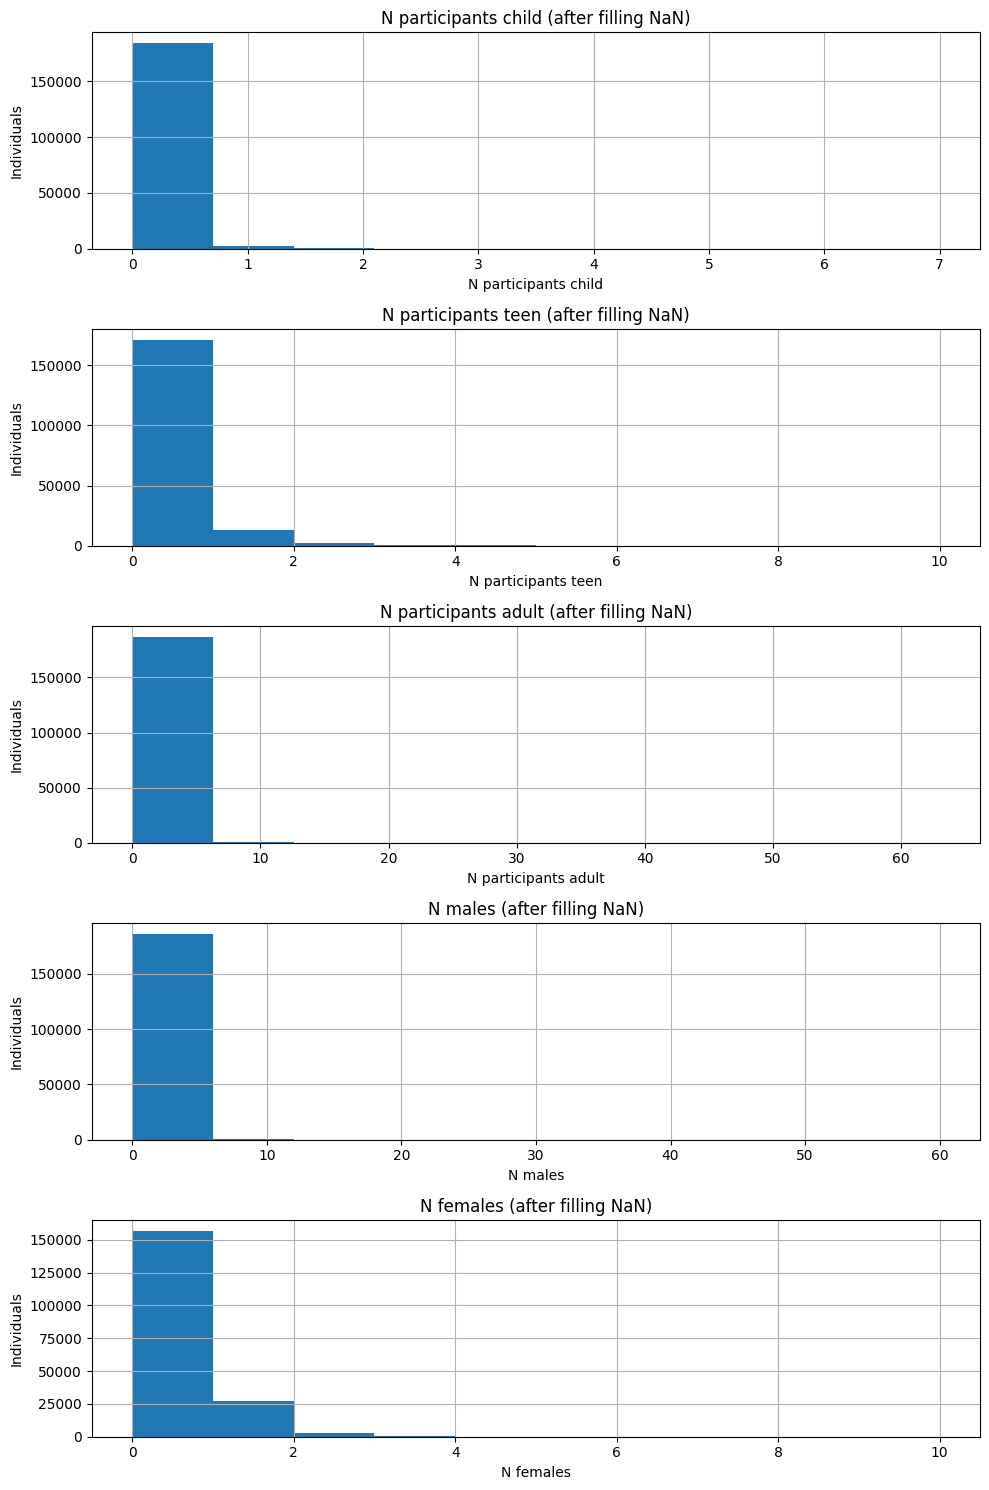

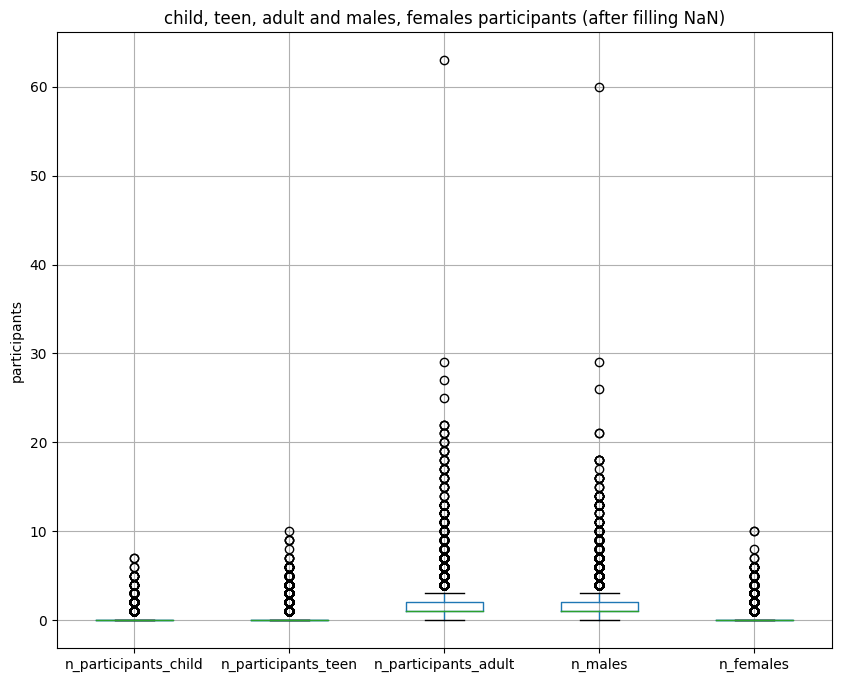

In [961]:
fig, axs = plt.subplots(5, figsize=(10, 15))  # Create 5 subplots

columns = ["n_participants_child", "n_participants_teen", "n_participants_adult", "n_males", "n_females"]
titles = ["N participants child (after filling NaN)", "N participants teen (after filling NaN)", "N participants adult (after filling NaN)", "N males (after filling NaN)", "N females (after filling NaN)"]
xlabels = ["N participants child", "N participants teen", "N participants adult", "N males", "N females"]
ylabels = ["Individuals"] * 5  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()


df.boxplot(column=["n_participants_child","n_participants_teen", "n_participants_adult",  "n_males", "n_females"], figsize=(10,8))
plt.title("child, teen, adult and males, females participants (after filling NaN)")
plt.ylabel("participants")
plt.show()

In [962]:
df[columns].describe()

,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
count,187534.0,187534.0,187534.0,187534.0,187534.0
mean,0.019255,0.112428,1.451971,1.397587,0.186068
std,0.167117,0.416448,1.146867,1.079249,0.457206
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,1.0,1.0,0.0
50%,0.0,0.0,1.0,1.0,0.0
75%,0.0,0.0,2.0,2.0,0.0
max,7.0,10.0,63.0,60.0,10.0


As we can see from the plots before and after filling NaN values, there is no relevant change in the distributions of these variables 

## N killed, injured, arrested, unharmed

N killed and N injured have no NaN values after the previous steps of cleaning, so we proceed to fix N arrested and N unharmed missing values.

In [963]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 187534 entries, 83331 to 188720
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n_killed    187534 non-null  Float64
 1   n_injured   187534 non-null  Float64
 2   n_arrested  164238 non-null  Float64
 3   n_unharmed  164238 non-null  Float64
dtypes: Float64(4)
memory usage: 7.9 MB


We check if each column in n_[killed, injured, arrested, unharmed] does not exceed the n of participants to that incident and the result is that no record exceeds this number.  

In [964]:
columns_to_check = ['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']
for column in columns_to_check:
    df.loc[df[column] > df['n_participants'], column] = np.nan

In [965]:
df[columns_to_check].info()

<class 'pandas.core.frame.DataFrame'>
Index: 187534 entries, 83331 to 188720
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n_killed    187521 non-null  Float64
 1   n_injured   187304 non-null  Float64
 2   n_arrested  164143 non-null  Float64
 3   n_unharmed  163604 non-null  Float64
dtypes: Float64(4)
memory usage: 7.9 MB


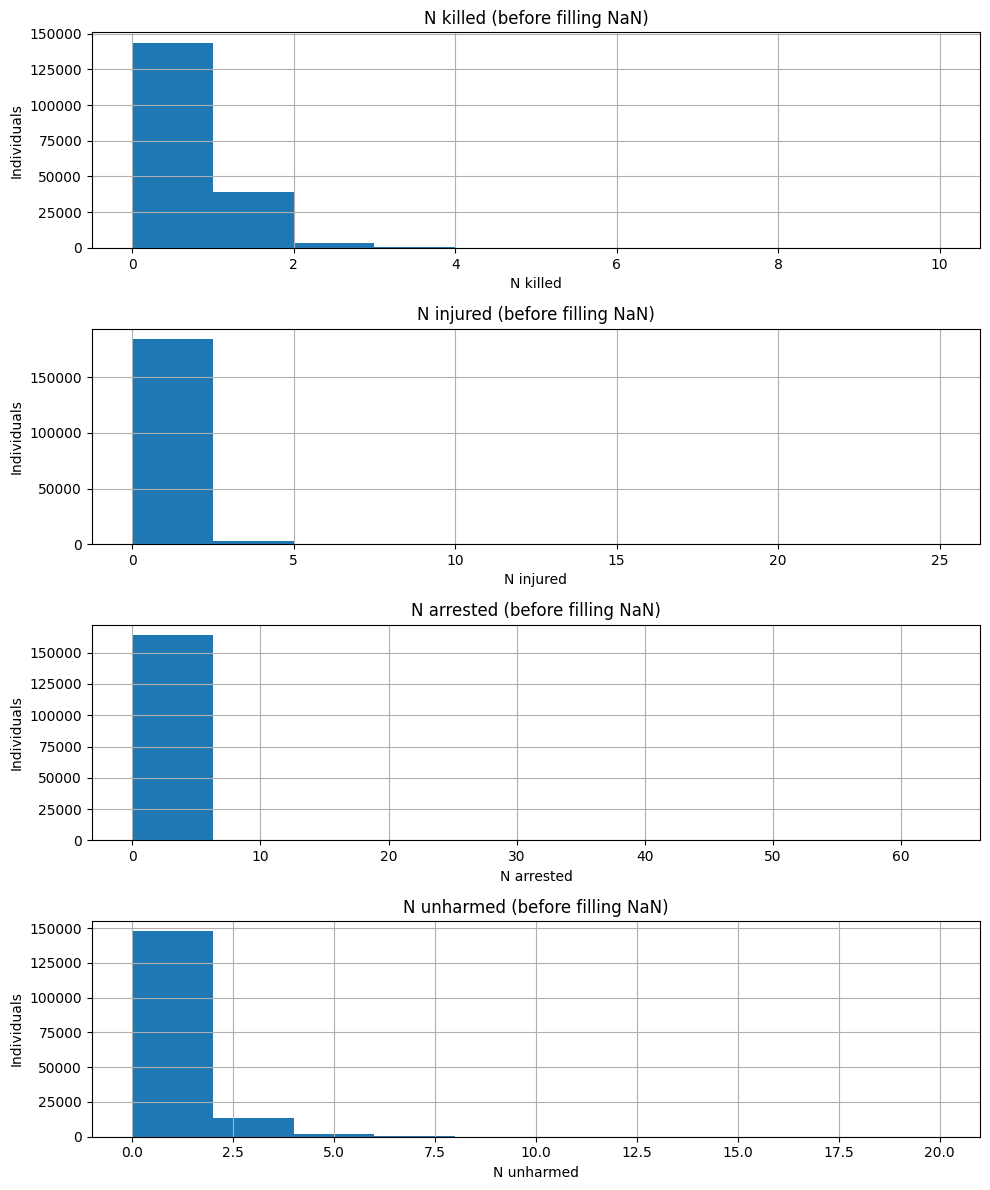

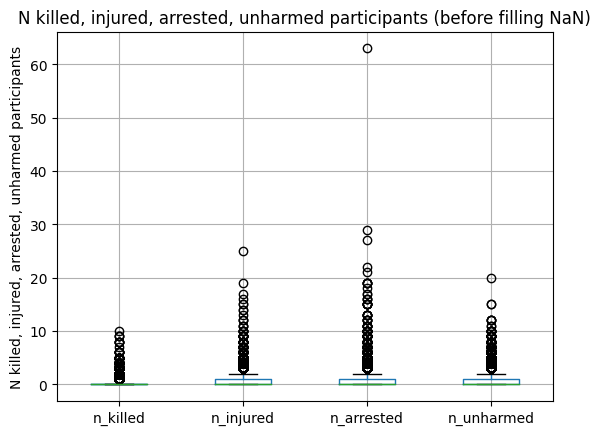

In [966]:
fig, axs = plt.subplots(4, figsize=(10, 12))  # Create 5 subplots

titles = ["N killed (before filling NaN)", "N injured (before filling NaN)", "N arrested (before filling NaN)", "N unharmed (before filling NaN)"]
xlabels = ["N killed", "N injured", "N arrested", "N unharmed"]
ylabels = ["Individuals"] * 4  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns_to_check, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()

df.boxplot(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (before filling NaN)")
plt.ylabel("N killed, injured, arrested, unharmed participants")
plt.show()

In [967]:
df[columns_to_check].describe()

,n_killed,n_injured,n_arrested,n_unharmed
count,187521.0,187304.0,164143.0,163604.0
mean,0.262029,0.488009,0.495873,0.443987
std,0.513434,0.710006,0.853363,0.87299
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,1.0,1.0,1.0
max,10.0,25.0,63.0,20.0


We put to 0 arrested and unharmed in all the cases in which there is 0 participants.

In [968]:
df.loc[df["n_participants"] == 0, ['n_arrested', 'n_unharmed']] = 0

Fill the remaining null values with the mean

In [969]:
def fillna_group_arrested_unharmed(group):
    group["n_killed"] = group["n_killed"].fillna(np.round(group["n_killed"].mean(),0))
    group["n_injured"] = group["n_injured"].fillna(np.round(group["n_injured"].mean(),0))
    group["n_arrested"] = group["n_arrested"].fillna(np.round(group["n_arrested"].mean(),0))
    group["n_unharmed"] = group["n_unharmed"].fillna(np.round(group["n_unharmed"].mean(),0))
    return group

In [970]:
df = df.groupby("n_participants").apply(fillna_group_arrested_unharmed).reset_index(drop=True)

In [971]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n_killed    187534 non-null  Float64
 1   n_injured   187534 non-null  Float64
 2   n_arrested  187534 non-null  Float64
 3   n_unharmed  187534 non-null  Float64
dtypes: Float64(4)
memory usage: 6.4 MB


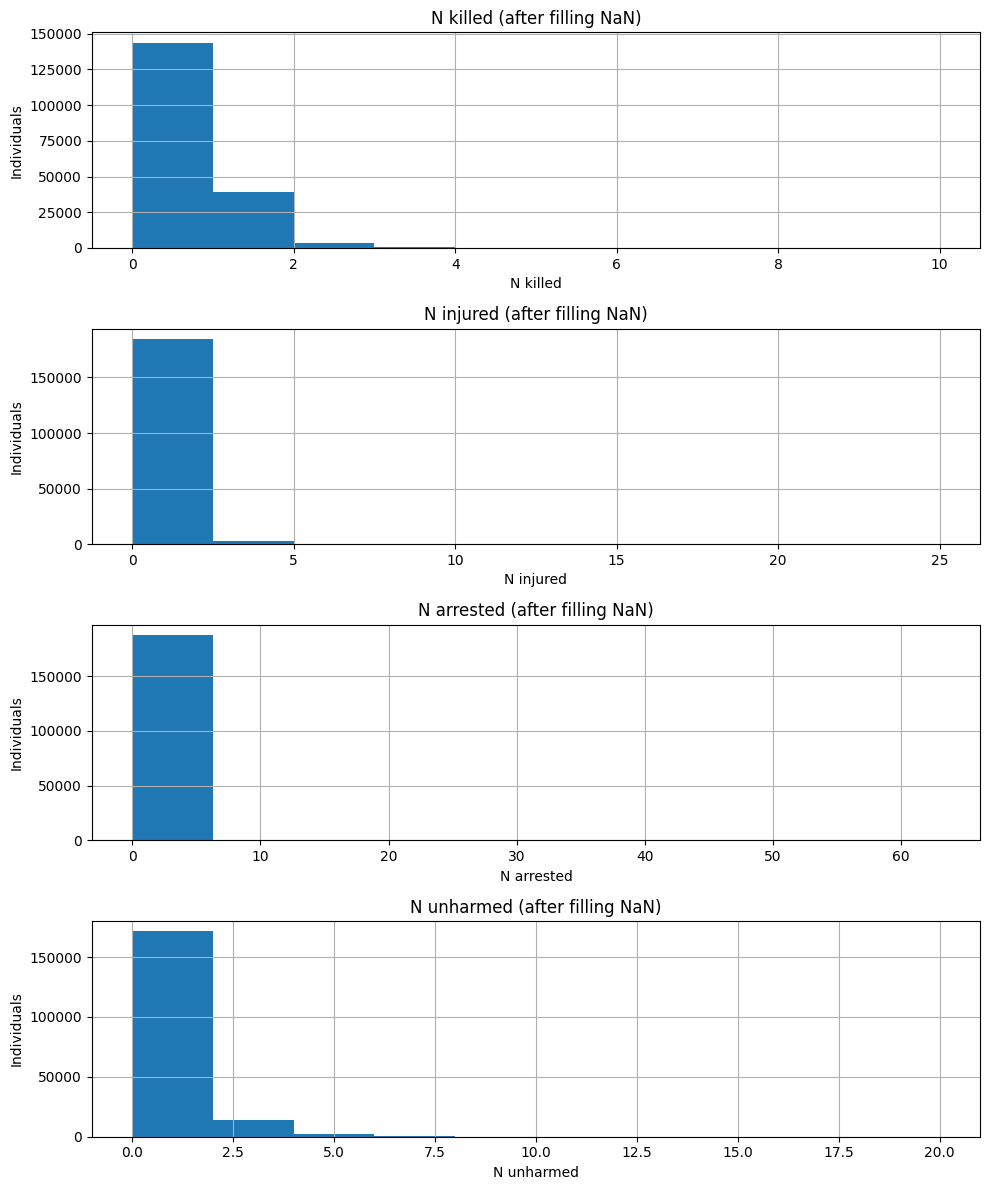

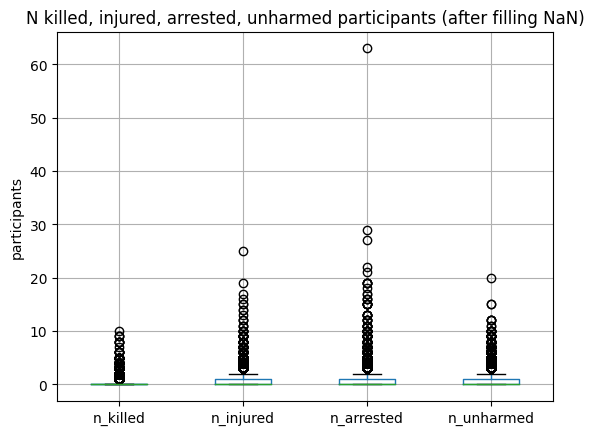

In [972]:
fig, axs = plt.subplots(4, figsize=(10, 12))  

titles = ["N killed (after filling NaN)", "N injured (after filling NaN)", "N arrested (after filling NaN)", "N unharmed (after filling NaN)"]
xlabels = ["N killed", "N injured", "N arrested", "N unharmed"]
ylabels = ["Individuals"] * 4 

for ax, column, title, xlabel, ylabel in zip(axs, columns_to_check, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()

df.boxplot(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (after filling NaN)")
plt.ylabel("participants")
plt.show()

In [973]:
df[columns_to_check].describe()

,n_killed,n_injured,n_arrested,n_unharmed
count,187534.0,187534.0,187534.0,187534.0
mean,0.262011,0.487666,0.439862,0.393811
std,0.513421,0.709803,0.815828,0.830017
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,1.0,1.0,1.0
max,10.0,25.0,63.0,20.0


As we can see from the plots before and after filling NaN values, there is no major change in the distributions of these variables 

# Incident characteristics 1

In [974]:
df['incident_characteristics1'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 187534 entries, 0 to 187533
Series name: incident_characteristics1
Non-Null Count   Dtype 
--------------   ----- 
187274 non-null  string
dtypes: string(1)
memory usage: 1.4 MB


We decided to fill the missing values for this attribute with its mode (they are few, so we didn't plot the distribution)

In [975]:
df['incident_characteristics1'] = df['incident_characteristics1'].fillna(df['incident_characteristics1'].mode()[0])

In [976]:
""" import pandas as pd
print(df['incident_characteristics1'].mode()[0])
print(df['incident_characteristics1']) """

" import pandas as pd\nprint(df['incident_characteristics1'].mode()[0])\nprint(df['incident_characteristics1']) "

# Incident characteristics 2

In [977]:
df['incident_characteristics2'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 187534 entries, 0 to 187533
Series name: incident_characteristics2
Non-Null Count   Dtype 
--------------   ----- 
111662 non-null  string
dtypes: string(1)
memory usage: 1.4 MB


In [978]:
print(f" percentage of null values: {df['incident_characteristics2'].isna().sum() / len(df['incident_characteristics2'])}")

 percentage of null values: 0.40457730331566544


For now, since incident_characteristics2 has 40% of missing values and add only further details that we consider useless for our analysis, we decided to drop it. 

In [979]:
df[df['incident_characteristics1'] == "Shot - Wounded/Injured" ][['incident_characteristics1','incident_characteristics2']].value_counts(dropna=False).head()

incident_characteristics1  incident_characteristics2                        
Shot - Wounded/Injured     <NA>                                                 36780
                           Shot - Dead (murder, accidental, suicide)             6737
                           Drive-by (car to street, car to car)                  5588
                           Accidental Shooting                                   3066
                           Armed robbery with injury/death and/or evidenc...     2879
Name: count, dtype: int64

In [980]:
df.drop(columns=['incident_characteristics2'], inplace=True)

# Correlation Matrix Analysis

In [981]:
corr_matrix = df[['participant_age1', 'participant_age_group1',
       'participant_gender1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'povertyPercentage']].corr(numeric_only=True, method='pearson')
corr_matrix

,participant_age1,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,povertyPercentage
participant_age1,1.000000,0.877400,0.945248,0.927023,-0.176063,-0.257462,0.108656,-0.065212,0.067647,0.145097,-0.122367,-0.024011,-0.006590,-0.029404,0.035638
min_age_participants,0.877400,1.000000,0.951413,0.811674,-0.225789,-0.304671,-0.020935,-0.193136,-0.019074,0.060142,-0.153039,-0.107599,-0.045776,-0.183708,0.015814
avg_age_participants,0.945248,0.951413,1.000000,0.948430,-0.174853,-0.288038,0.085870,-0.100455,0.061815,0.134574,-0.121849,-0.051313,-0.018817,-0.063962,0.032582
max_age_participants,0.927023,0.811674,0.948430,1.000000,-0.109087,-0.233740,0.195179,0.015612,0.140825,0.194869,-0.076142,0.023436,0.013645,0.076184,0.045559
n_participants_child,-0.176063,-0.225789,-0.174853,-0.109087,1.000000,0.011801,-0.013162,0.084684,0.143355,0.063632,0.053361,-0.011199,0.110597,0.131445,0.031221
n_participants_teen,-0.257462,-0.304671,-0.288038,-0.233740,0.011801,1.000000,-0.091879,0.249781,0.095079,0.015531,0.111810,0.191621,0.082485,0.262196,0.013198
n_participants_adult,0.108656,-0.020935,0.085870,0.195179,-0.013162,-0.091879,1.000000,0.858877,0.392520,0.214708,0.335026,0.408911,0.493112,0.926683,0.067485
n_males,-0.065212,-0.193136,-0.100455,0.015612,0.084684,0.249781,0.858877,1.000000,0.052365,0.168209,0.336621,0.434907,0.493109,0.923991,0.059580
n_females,0.067647,-0.019074,0.061815,0.140825,0.143355,0.095079,0.392520,0.052365,1.000000,0.178922,0.167129,0.169556,0.188492,0.430273,0.052073
n_killed,0.145097,0.060142,0.134574,0.194869,0.063632,0.015531,0.214708,0.168209,0.178922,1.000000,-0.182932,-0.031980,-0.103562,0.220567,0.066325


<Axes: >

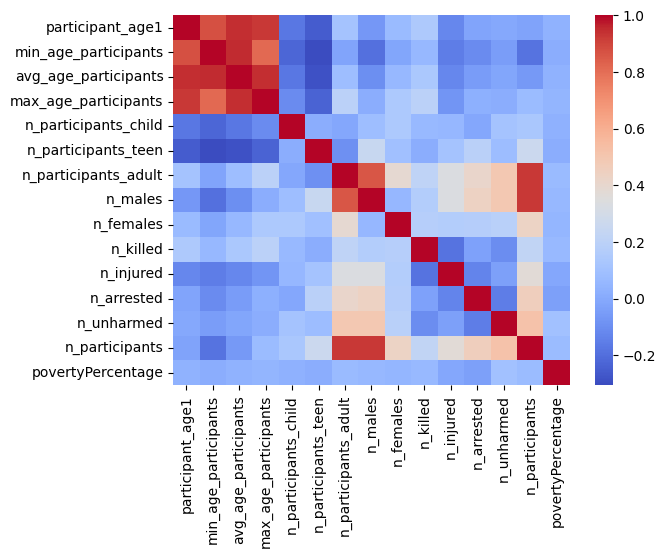

In [982]:
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

As resulted from the plotting of correlation matrix, we can see that attributes related to the age i.e. participant_age1, min_age_participants, 	avg_age_participants, max_age_participants are all high correlated.
We decided to drop everything except avg_age_participants which has the most high correlation w.r.t. other attributes (>0.90) and gives us more general information about all the participants (w.r.t. e.g. participant_age1, which takes the age of one random person involved in the incident.)

Deleting participant_age1, also participant_age_group1 and participant_gender1 becomes useless (also because these information can be inferred respectively from n_participant_[child,teen,adult] and n_[males,females]), so we delete also these attributes. 

We notice that also n_participants, n_participants_adult, n_males are highly correlated.  
We observe that we can derive n_participants_adult, n_males from n_participants and viceversa, as n_participants_adult + n_participants_teen + n_participants_child = n_males + n_females = n_participants, so we decide to keep the most general information, so only n_participants     

In [983]:
df[(df['n_participants'] != (df['n_males'] + df['n_females'])) | (df['n_participants'] != (df['n_participants_child'] + df['n_participants_teen'] + df['n_participants_adult']))]

,date,state,city_or_county,address,latitude,longitude,congressional_district,participant_age1,participant_age_group1,participant_gender1,...,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,year,povertyPercentage,party,candidatevotes,totalvotes


Before dropping all the attributes, we proceed to fill also avg_age_participants

## Filling missing values for avg_age_participants

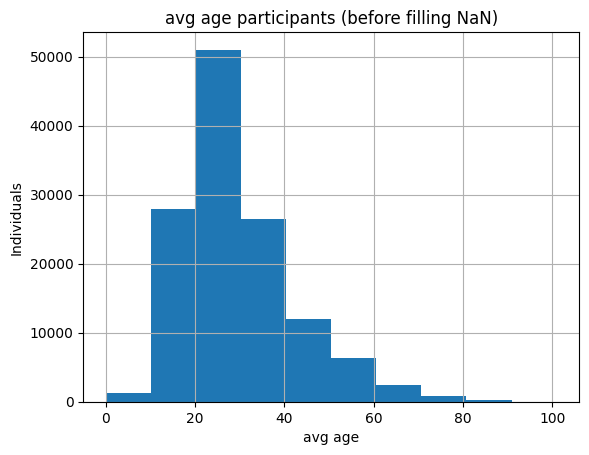

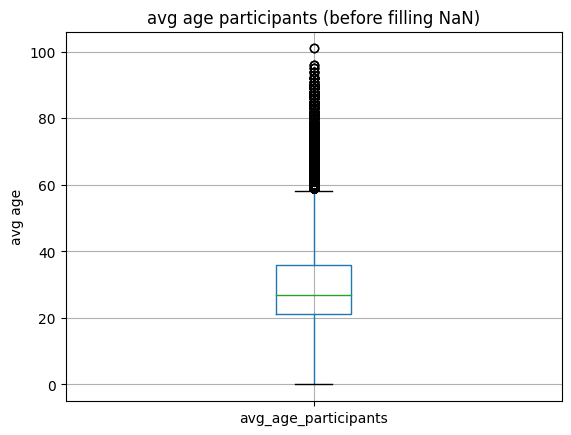

In [984]:
df.hist(column=["avg_age_participants"])
plt.title("avg age participants (before filling NaN)")
plt.xlabel("avg age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=["avg_age_participants"])
plt.title("avg age participants (before filling NaN)")
plt.ylabel("avg age")
plt.show()

In [985]:
df["avg_age_participants"].describe()

count     128775.0
mean     29.955977
std      12.460553
min            0.0
25%           21.0
50%           27.0
75%           36.0
max          101.0
Name: avg_age_participants, dtype: Float64

We decide to fill the missing values of avg_age_participants with the mean.

In particular we assume that:
- if there is more than 1 adult, fill the null value with the general mean age(as 1. the mean of n_participants is around 1.5 and 2. n_participants and n_participants_adult is high correlated), 
- if no adult and at least 1 teen is present, fill the null value with avg age of teens (see 1. above)
- if no adult and no teen are present, fill the null value value with the avg age of children  

In [986]:
mean_age_before_correction = df["avg_age_participants"].mean()
df_adult = df[df["n_participants_adult"] > 0].copy() 
df_teen = df[(df["n_participants_adult"] == 0) & (df["n_participants_teen"] > 0)].copy()
df_child = df[(df["n_participants_adult"] == 0) & (df["n_participants_teen"] == 0) & (df["n_participants_child"] > 0)].copy()
df_remainder = df[(df["n_participants_adult"] == 0) & (df["n_participants_teen"] == 0) & (df["n_participants_child"] == 0)].copy()



df_adult["avg_age_participants"] = df_adult["avg_age_participants"].fillna(round(mean_age_before_correction,0))
df_teen["avg_age_participants"] = df_teen["avg_age_participants"].fillna(round(df_teen["avg_age_participants"].mean(),0))
df_child["avg_age_participants"] = df_child["avg_age_participants"].fillna(round(df_child["avg_age_participants"].mean(),0))


df = pd.concat([df_adult, df_teen, df_child, df_remainder])

df['avg_age_participants'].info()

<class 'pandas.core.series.Series'>
Index: 187534 entries, 20871 to 20869
Series name: avg_age_participants
Non-Null Count   Dtype  
--------------   -----  
166664 non-null  Float64
dtypes: Float64(1)
memory usage: 3.0 MB


The remaining records to fill have all participants information equals to 0, so we decided to replace them with the global mean to not affect the distribution of the age 

In [987]:
print(len(df_remainder))
df["avg_age_participants"] = df["avg_age_participants"].fillna(round(mean_age_before_correction, 0))

20870


In [988]:
col = ['participant_age1', 'participant_age_group1',
       'participant_gender1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants','incident_characteristics1']
df_remainder[col].value_counts(dropna=False).head(100)

participant_age1  participant_age_group1  participant_gender1  min_age_participants  avg_age_participants  max_age_participants  n_participants_child  n_participants_teen  n_participants_adult  n_males  n_females  n_killed  n_injured  n_arrested  n_unharmed  n_participants  incident_characteristics1                        
<NA>              <NA>                    <NA>                 <NA>                  <NA>                  <NA>                  0                     0                    0                     0.0      0.0        0.0       0.0        0.0         0.0         0.0             Shots Fired - No Injuries                            11212
                                                                                                                                                                                                                                                                                   Non-Shooting Incident                                 4746
       

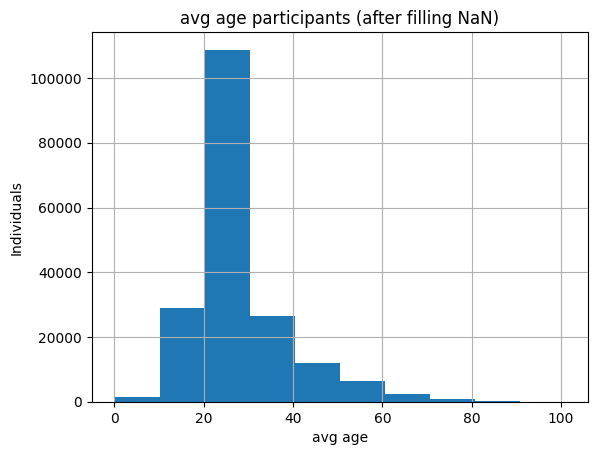

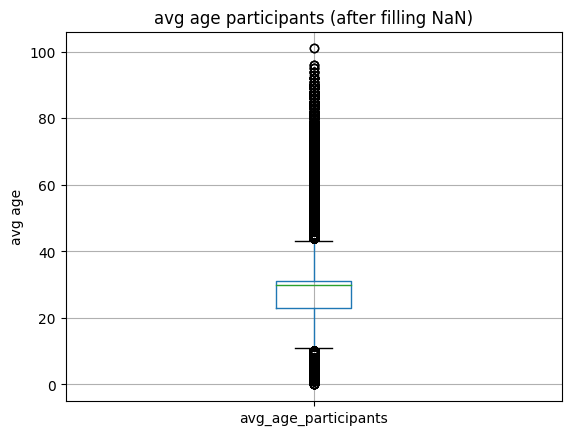

In [989]:
df.hist(column=["avg_age_participants"])
plt.title("avg age participants (after filling NaN)")
plt.xlabel("avg age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=["avg_age_participants"])
plt.title("avg age participants (after filling NaN)")
plt.ylabel("avg age")
plt.show()

In [990]:
outlier_lowerb = df[df["avg_age_participants"] < (23-(31-23)*1.5)]['avg_age_participants'].count()
outlier_upperb = df[df["avg_age_participants"] > (31+(31-23)*1.5)]['avg_age_participants'].count()
outlier_lowerb + outlier_upperb

19143

We left these outliers because they are all between 0 and 120, so all possible ages, we maintain it and see how clustering analysis goes

In [991]:
df["avg_age_participants"].describe()

count     187534.0
mean     29.887716
std      10.385832
min            0.0
25%           23.0
50%           30.0
75%           31.0
max          101.0
Name: avg_age_participants, dtype: Float64

## Dropping all high correlated attributes

In [992]:
df.drop(columns=['participant_age1', 'min_age_participants', 'max_age_participants', 'participant_age_group1', 'participant_gender1', 'n_participants_adult', 'n_males'], inplace=True)

# Definition of Indicators (provvisorio)

In [993]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187534 entries, 20871 to 20869
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       187534 non-null  datetime64[ns]
 1   state                      187534 non-null  string        
 2   city_or_county             187534 non-null  string        
 3   address                    174666 non-null  string        
 4   latitude                   187534 non-null  float64       
 5   longitude                  187534 non-null  float64       
 6   congressional_district     187534 non-null  Int64         
 7   avg_age_participants       187534 non-null  Float64       
 8   n_participants_child       187534 non-null  Int64         
 9   n_participants_teen        187534 non-null  Int64         
 10  n_females                  187534 non-null  Float64       
 11  n_killed                   187534 non-null  Float64   

In [997]:
print(sorted(df['incident_characteristics1'].unique()))
""" ATF/LE Confiscation/Raid/Arrest (confisca di qualcosa)
Accidental Shooting (Shooting)
Animal shot/killed (Animal)
Armed robbery with injury/death and/or evidence
"""

category_1 = ['Suicide - Attempt', 'Suicide^']
category_2 = ['ATF/LE Confiscation/Raid/Arrest', 'TSA Action', 'Gun at school, no death/injury - elementary/secondary school', 'Institution/Group/Business', 'Criminal act with stolen gun',
              'Brandishing/flourishing/open carry/lost/found', 'Gun buy back action', 'Stolen/Illegally owned gun{s} recovered during arrest/warrant', 
              'Possession (gun(s) found during commission of other crimes)', 'Unlawful purchase/sale', 'BB/Pellet/Replica gun', 'School Incident', 'Possession of gun by felon or prohibited person',
              'Under the influence of alcohol or drugs (only applies to the subject/suspect/perpetrator )']

category_3 = ['Drug involvement', 'Gang involvement']

category_4 = ['Shot - Wounded/Injured', 'Shot - Dead (murder, accidental, suicide)', 'Murder/Suicide', 'Accidental Shooting', 'Drive-by (car to street, car to car)', 
              'Implied Weapon', 'Attempted Murder/Suicide (one variable unsuccessful)', 'Sex crime involving firearm', 'Defensive Use', 
              'Bar/club incident - in or around establishment', 'Pistol-whipping', 'Officer Involved Incident']

category_5 = ['Car-jacking', 'Domestic Violence', 'Hate crime', 'House party', 'Road rage', 'Non-Aggression Incident', 'LOCKDOWN/ALERT ONLY: No GV Incident Occurred Onsite', 'Child Involved Incident']

category_6 = [ 'Home Invasion', 'Gun shop robbery or burglary', 'Armed robbery with injury/death and/or evidence of DGU found',  'Gun range/gun shop/gun show shooting',
              'Gun(s) stolen from owner', 'Guns stolen from law enforcement', 'Kidnapping/abductions/hostage',]

category_7 = ['Shots Fired - No Injuries', 'Shots fired, no action (reported, no evidence found)', 'ShotSpotter', 'Animal shot/killed', 'Non-Shooting Incident']

category_8 = ['Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)', 'Spree Shooting (multiple victims, multiple locations)']

['ATF/LE Confiscation/Raid/Arrest', 'Accidental Shooting', 'Animal shot/killed', 'Armed robbery with injury/death and/or evidence of DGU found', 'Attempted Murder/Suicide (one variable unsuccessful)', 'BB/Pellet/Replica gun', 'Bar/club incident - in or around establishment', 'Brandishing/flourishing/open carry/lost/found', 'Car-jacking', 'Child Involved Incident', 'Criminal act with stolen gun', 'Defensive Use', 'Domestic Violence', 'Drive-by (car to street, car to car)', 'Drug involvement', 'Gang involvement', 'Gun at school, no death/injury - elementary/secondary school', 'Gun buy back action', 'Gun range/gun shop/gun show shooting', 'Gun shop robbery or burglary', 'Gun(s) stolen from owner', 'Guns stolen from law enforcement', 'Hate crime', 'Home Invasion', 'House party', 'Implied Weapon', 'Institution/Group/Business', 'Kidnapping/abductions/hostage', 'LOCKDOWN/ALERT ONLY: No GV Incident Occurred Onsite', 'Mass Shooting (4+ victims injured or killed excluding the subject/suspect/per

In [923]:
df[df['incident_characteristics1'] == 'Gun buy back action'].value_counts()

date        state          city_or_county                   latitude  longitude  congressional_district  avg_age_participants  n_participants_child  n_participants_teen  n_females  n_killed  n_injured  n_arrested  n_unharmed  n_participants  incident_characteristics1  povertyPercentage  party       candidatevotes  totalvotes  child_percentage_per_district  teen_percentage_per_district  killed_percentage_per_district  injured_percentage_per_district  arrested_percentage_per_district  unharmed_percentage_per_district  killed_rate  injured_rate  arrested_rate  survival_rate  n_harmed  winning_party_percentage
2014-06-28  connecticut    New Haven                        41.3048   -72.9230   3                       30.0                  0                     0                    0.0        0.0       0.0        0.0         0.0         0.0             Gun buy back action        9.2                DEMOCRAT    130009          209939      0.0                            0.0                        

In [891]:
#How many males are involved in the incident w.r.t. the total number of males involved in incidents for the same congressional district and in the same date
#df["males_percentage_per_district"] = df["n_males"] /  df.groupby([df.date.dt.month,"state"])["n_males"].transform("mean")
#handling null value
#df.loc[np.isnan(df["males_percentage_per_district"]),"males_percentage_per_district"] = 0

#How many child and teen are involved in the incident w.r.t. the total number of males involved in incidents for the same congressional district and in the same date
df["child_percentage_per_district"] = df['n_participants_child'] /  df.groupby([df.date.dt.year,"state", "congressional_district"])["n_participants_child"].transform("sum") 
#handling null value
df.loc[np.isnan(df["child_percentage_per_district"]),"child_percentage_per_district"] = 0 

#How many child and teen are involved in the incident w.r.t. the total number of males involved in incidents for the same congressional district and in the same date
df["teen_percentage_per_district"] = df['n_participants_teen'] /  df.groupby([df.date.dt.year, "state", "congressional_district"])["n_participants_teen"].transform("sum") 
#handling null value
df.loc[np.isnan(df["teen_percentage_per_district"]),"teen_percentage_per_district"] = 0 


In [892]:
#How many killed people have been involved w.r.t the total killed people in the same congressional district in a given date
df["killed_percentage_per_district"] = df["n_killed"] /  df.groupby([df.date.dt.year, "state", "congressional_district"])["n_killed"].transform("sum")
df.loc[np.isnan(df["killed_percentage_per_district"]),"killed_percentage_per_district"] = 0

#How many injured people have been involved w.r.t the total injured people in the same congressional district in a given date
df["injured_percentage_per_district"] = df["n_injured"] /  df.groupby([df.date.dt.year, "state", "congressional_district"])["n_injured"].transform("sum")
df.loc[np.isnan(df["injured_percentage_per_district"]),"injured_percentage_per_district"] = 0

#How many arrested people have been involved w.r.t the total killed people in the same congressional district in a given date
df["arrested_percentage_per_district"] = df["n_arrested"] /  df.groupby([df.date.dt.year, "state","congressional_district"])["n_arrested"].transform("sum")
df.loc[np.isnan(df["arrested_percentage_per_district"]),"arrested_percentage_per_district"] = 0

#How many arrested people have been involved w.r.t the total killed people in the same congressional district in a given date
df["unharmed_percentage_per_district"] = df["n_unharmed"] /  df.groupby([df.date.dt.year, "state","congressional_district"])["n_unharmed"].transform("sum")
df.loc[np.isnan(df["unharmed_percentage_per_district"]),"unharmed_percentage_per_district"] = 0


In [893]:
#Ratio of killed people in the incidents w.r.t. the the average of killed  people in the same date
df["killed_rate"] = df["n_killed"] / df["n_participants"]
df.loc[np.isnan(df["killed_rate"]),"killed_rate"] = 0

#Ratio of injured people in the incidents w.r.t. the the average of injured people in the same date
df["injured_rate"] = df["n_injured"] / df["n_participants"]
df.loc[np.isnan(df["injured_rate"]),"injured_rate"] = 0

#Ratio of arrested people in the incidents w.r.t. the the average of arrested people in the same date
df["arrested_rate"] = df["n_arrested"] / df["n_participants"]
df.loc[np.isnan(df["arrested_rate"]),"arrested_rate"] = 0

#Ratio of unharmed people in the incidents w.r.t. the the average of unharmed people in the same date
df["survival_rate"] = df["n_unharmed"] / df["n_participants"]
df.loc[np.isnan(df["survival_rate"]),"survival_rate"] = 0

df["n_harmed"] = df['n_participants'] - df['n_unharmed']

In [894]:
# Percentage of votes of the winning party
df['winning_party_percentage'] = df['candidatevotes'] / df['totalvotes']
df.loc[np.isnan(df["winning_party_percentage"]),"winning_party_percentage"] = 0

In [895]:
col_to_plot = [
 'killed_percentage_per_district',
 'injured_percentage_per_district',
 'arrested_percentage_per_district',
 'unharmed_percentage_per_district',
 'killed_rate',
 'injured_rate',
 'arrested_rate',
 'survival_rate',
 'child_percentage_per_district',
 'teen_percentage_per_district',
 'winning_party_percentage',
 'avg_age_participants',
 'povertyPercentage',
 'n_females',
 'n_harmed'
 ]

corr_matrix_ind = df[col_to_plot].corr(numeric_only=True, method='pearson')
corr_matrix_ind

,killed_percentage_per_district,injured_percentage_per_district,arrested_percentage_per_district,unharmed_percentage_per_district,killed_rate,injured_rate,arrested_rate,survival_rate,child_percentage_per_district,teen_percentage_per_district,winning_party_percentage,avg_age_participants,povertyPercentage,n_females,n_harmed
killed_percentage_per_district,1.000000,0.005235,0.065448,-0.002204,0.539510,-0.185883,-0.086769,-0.093595,0.065129,0.060856,-0.054159,0.129176,-0.011949,0.134572,0.213746
injured_percentage_per_district,0.005235,1.000000,0.069418,0.112964,-0.123656,0.350164,-0.096869,-0.041011,0.056916,0.135944,-0.059248,-0.017038,-0.013304,0.091590,0.235830
arrested_percentage_per_district,0.065448,0.069418,1.000000,0.006361,-0.055524,-0.130148,0.376912,-0.102636,0.008346,0.141890,-0.048966,-0.011172,-0.011657,0.084252,0.314602
unharmed_percentage_per_district,-0.002204,0.112964,0.006361,1.000000,-0.090243,-0.109400,-0.124284,0.489178,0.073498,0.102707,-0.048954,0.009028,-0.011049,0.098078,-0.107193
killed_rate,0.539510,-0.123656,-0.055524,-0.090243,1.000000,-0.318578,-0.202969,-0.178348,0.016972,-0.010268,0.037563,0.130686,0.046410,0.040933,0.131312
injured_rate,-0.185883,0.350164,-0.130148,-0.109400,-0.318578,1.000000,-0.326986,-0.202026,0.014450,-0.007961,0.089826,-0.109933,-0.042033,-0.005063,0.153342
arrested_rate,-0.086769,-0.096869,0.376912,-0.124284,-0.202969,-0.326986,1.000000,-0.275590,-0.032503,0.053184,-0.100555,0.000421,-0.070094,0.010042,0.302173
survival_rate,-0.093595,-0.041011,-0.102636,0.489178,-0.178348,-0.202026,-0.275590,1.000000,0.032413,0.017129,-0.001388,0.004519,0.092699,0.084376,-0.325530
child_percentage_per_district,0.065129,0.056916,0.008346,0.073498,0.016972,0.014450,-0.032503,0.032413,1.000000,0.017512,-0.010395,-0.144844,0.009062,0.109145,0.050128
teen_percentage_per_district,0.060856,0.135944,0.141890,0.102707,-0.010268,-0.007961,0.053184,0.017129,0.017512,1.000000,-0.030243,-0.188539,-0.005658,0.064554,0.142373


<Axes: >

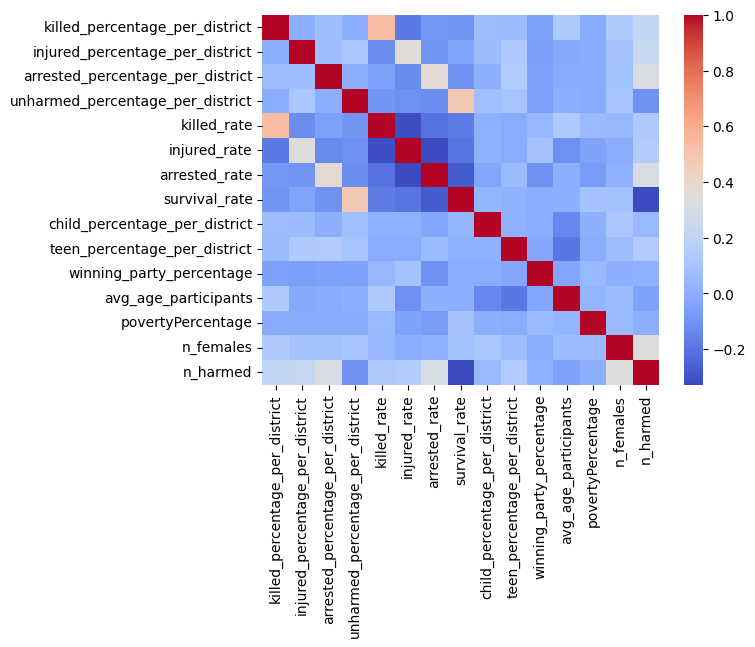

In [896]:
sns.heatmap(corr_matrix_ind, annot=False, cmap='coolwarm')

<Axes: >

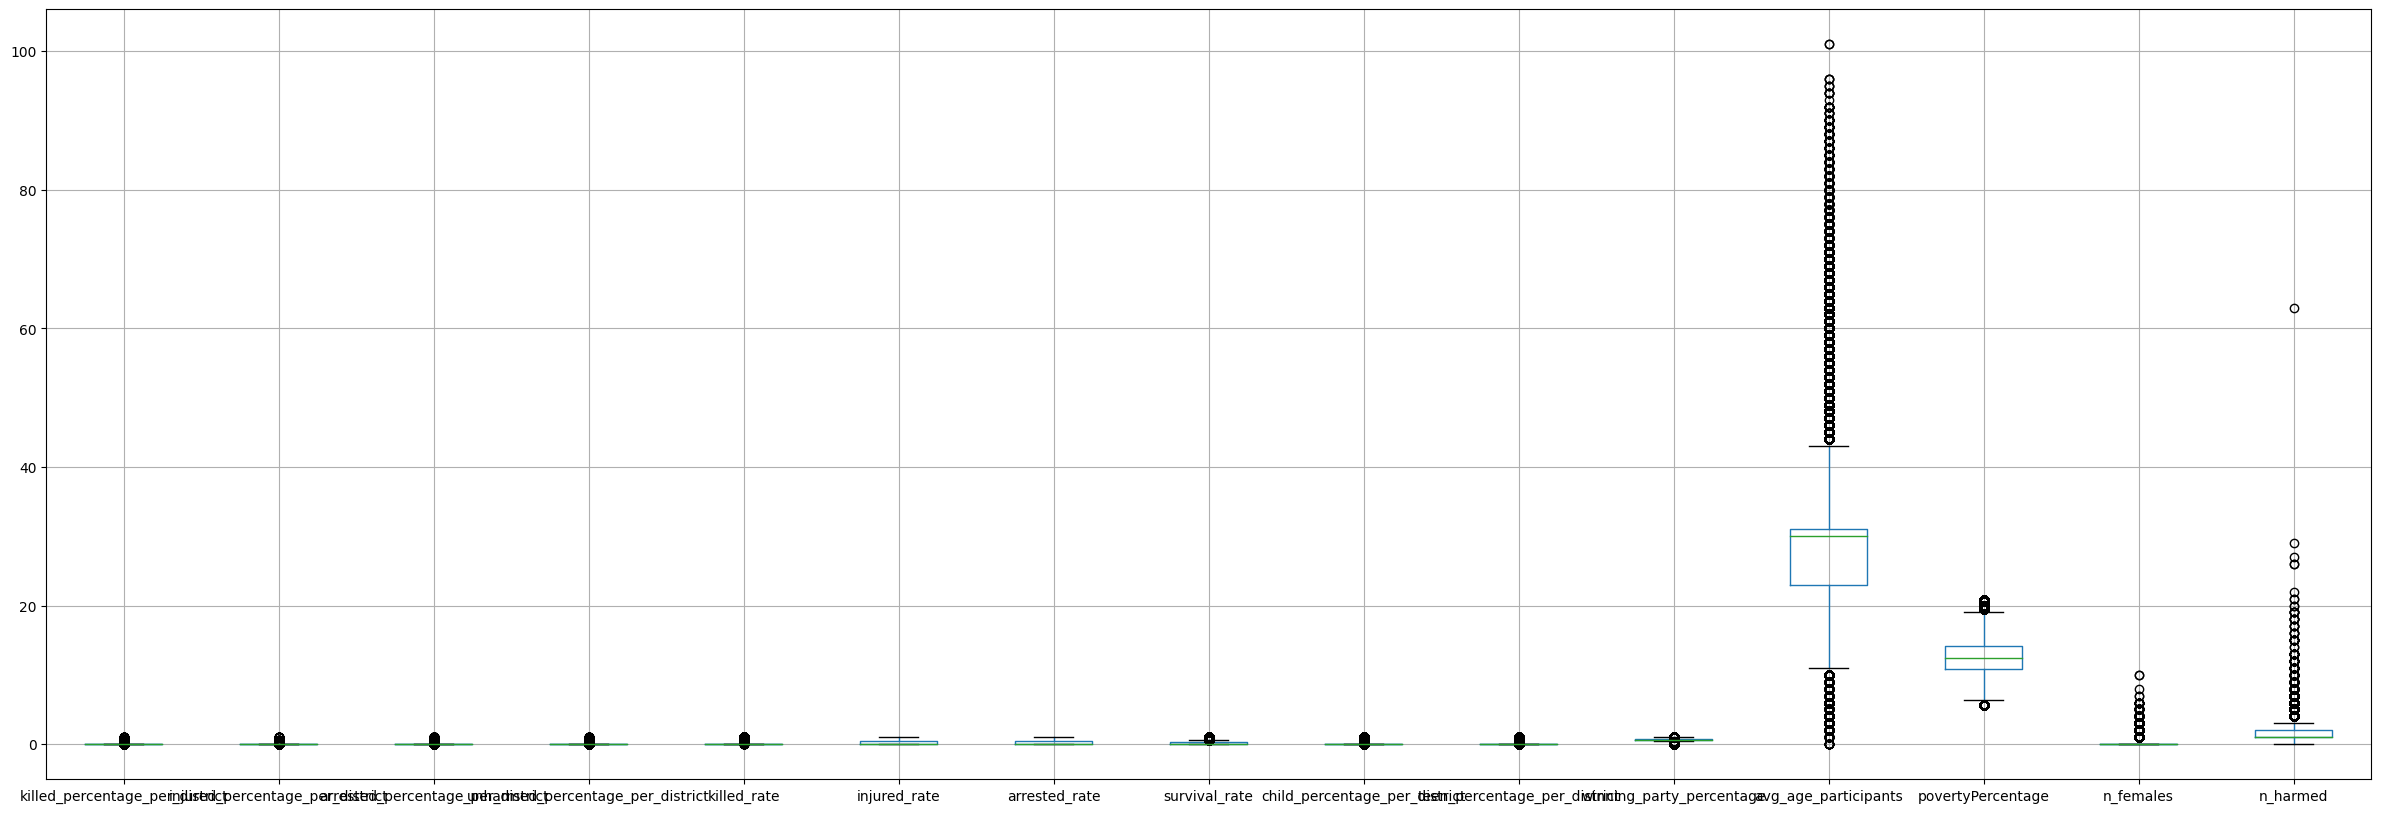

In [897]:
df[col_to_plot].boxplot(figsize=(30,10))

In [898]:
df[col_to_plot].describe()

,killed_percentage_per_district,injured_percentage_per_district,arrested_percentage_per_district,unharmed_percentage_per_district,killed_rate,injured_rate,arrested_rate,survival_rate,child_percentage_per_district,teen_percentage_per_district,winning_party_percentage,avg_age_participants,povertyPercentage,n_females,n_harmed
count,187534.0,187534.0,187534.0,187534.0,187534.0,187534.0,187534.0,187534.0,187534.0,187534.0,187534.0,187534.0,187534.00000,187534.0,187534.0
mean,0.009177,0.009182,0.00907,0.009156,0.163842,0.303845,0.248404,0.176173,0.005924,0.008825,0.681677,29.887716,12.67013,0.186068,1.189843
std,0.028988,0.026519,0.031469,0.031441,0.328084,0.410233,0.386724,0.326824,0.060906,0.048556,0.130526,10.385832,2.71095,0.457206,1.04303
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60000,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.59798,23.0,10.90000,0.0,1.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.668029,30.0,12.40000,0.0,1.0
75%,0.0,0.007299,0.008696,0.001808,0.0,0.5,0.5,0.25,0.0,0.0,0.749041,31.0,14.20000,0.0,2.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,101.0,20.80000,10.0,63.0


As we can see from the count of the describe, the indicators has no missing values. 

Moreover, we decide to keep also the outliers as they are coherent with the ones in the numeric attributes analyzed before

For now we keep all the indicators because we think they describe better the incidents, but later we probably drop the most correlated ones.

# Further Attributes dropped

As observed in the DU address will be dropped, moreover we will drop also year and notes because the former is a result of the data integration, useless because is redundant as we have the attribute date, the latter is useless because is only a string of text, used only in the data understanding

In [899]:
df.drop(columns=['notes', 'year', 'address'], inplace=True)

In [900]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187534 entries, 20871 to 20869
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              187534 non-null  datetime64[ns]
 1   state                             187534 non-null  string        
 2   city_or_county                    187534 non-null  string        
 3   latitude                          187534 non-null  float64       
 4   longitude                         187534 non-null  float64       
 5   congressional_district            187534 non-null  Int64         
 6   avg_age_participants              187534 non-null  Float64       
 7   n_participants_child              187534 non-null  Int64         
 8   n_participants_teen               187534 non-null  Int64         
 9   n_females                         187534 non-null  Float64       
 10  n_killed                          

# Export the dataframe after the data preparation

In [901]:
df.to_csv('df_after_dp.csv', index=False)